In [2]:
#Importing useful libraries
import tensorflow as tf
import keras
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display as display_fn
from IPython.display import Image, clear_output

In [3]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [4]:
%load_ext tensorboard

In [5]:
#Path of the content and style image.
content_path = '/content/drive/MyDrive/NST/Images/content_image.jpg'
style_path = '/content/drive/MyDrive/NST/Images/style_image.jpg'


In [6]:
#Basic Image preprocessing
def load_img(img_path):
    ''' This blocks converts image to a tensor and scales to 512 pixel while
    maintaning aspect ratio.'''
    max_dim = 512
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img) #converts jpeg image to 3 dimensional rgb 
    img = tf.image.convert_image_dtype(img,tf.float32) 

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim/long_dim

    new_shape = tf.cast(shape*scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :] #extra dimension to create batch 
    img = tf.image.convert_image_dtype(img, tf.uint8)

    return img

def load_images(content_path, style_path):
    content_image = load_img("{}".format(content_path))
    style_image = load_img("{}".format(style_path))

    return content_image, style_image

def imshow(img, title=None):
    if(len(img.shape) > 3):
        img = tf.squeeze(img, axis=0)
    
    plt.imshow(img)
    if title:
        plt.title(title) 


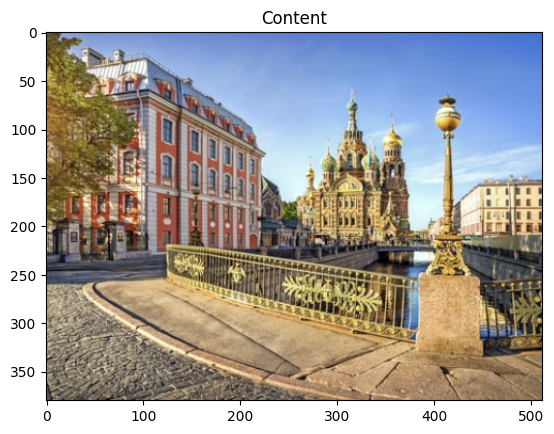

In [7]:
content_image, style_image = load_images(content_path, style_path)

imshow(content_image, 'Content')

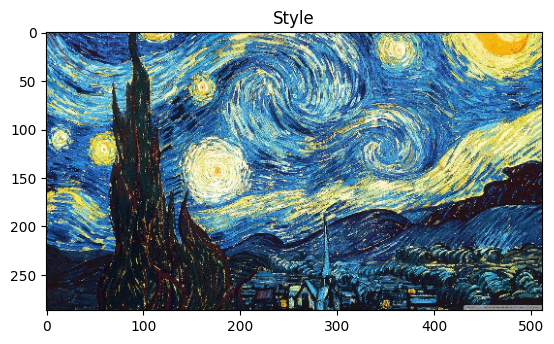

In [8]:
imshow(style_image, 'Style')

In [9]:
# download the inception model and inspect the layers
K.clear_session()

Tmp_inception = tf.keras.applications.InceptionV3()
Tmp_inception.summary()

# delete temporary model
del Tmp_inception

96112376/96112376 [==============================] - 6s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)           

In [10]:
# choose the content layer and put in a list
content_layers = ['conv2d_93']

# choose the five style layers of interest
style_layers = ['conv2d', 
                'conv2d_1', 
                'conv2d_2', 
                'conv2d_3', 
                'conv2d_4']

# combine the content and style layers into one list
content_and_style_layers = style_layers + content_layers 

# count the number of content layers and style layers.
NUM_CONTENT_LAYERS = len(content_layers)
NUM_STYLE_LAYERS = len(style_layers)

In [11]:
def inception_model(layer_names):
    '''Load InceptionV3 model with imagnet weights.'''
    inception = tf.keras.applications.inception_v3.InceptionV3(include_top=False, weights='imagenet')

    inception.trainable = False

    output_layers = [inception.get_layer(name).output for name in layer_names]

    model = tf.keras.models.Model(inputs=inception.input, outputs = output_layers)

    return model

In [12]:
K.clear_session()

inception = inception_model(content_and_style_layers)
inception

87910968/87910968 [==============================] - 5s 0us/step


In [13]:
def get_style_loss(features, targets):

  style_loss = tf.reduce_mean(tf.square(features-targets))

  return style_loss

In [14]:
def get_content_loss(features, targets):

  content_loss = 0.5*tf.reduce_sum(tf.square(features - targets))

  return content_loss

In [15]:
def gram_matrix(input_tensor):

  gram = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)

  input_shape = tf.shape(input_tensor)
  height = input_shape[1]
  width = input_shape[2]

  num_locations = tf.cast(height*width, tf.float32)

  scaled_gram = gram/num_locations

  return scaled_gram

In [16]:
tmp_layer_list = [layer.output for layer in inception.layers]
tmp_layer_list

[<KerasTensor: shape=(None, None, None, 3) dtype=float32 (created by layer 'input_1')>,
 <KerasTensor: shape=(None, None, None, 32) dtype=float32 (created by layer 'conv2d')>,
 <KerasTensor: shape=(None, None, None, 32) dtype=float32 (created by layer 'batch_normalization')>,
 <KerasTensor: shape=(None, None, None, 32) dtype=float32 (created by layer 'activation')>,
 <KerasTensor: shape=(None, None, None, 32) dtype=float32 (created by layer 'conv2d_1')>,
 <KerasTensor: shape=(None, None, None, 32) dtype=float32 (created by layer 'batch_normalization_1')>,
 <KerasTensor: shape=(None, None, None, 32) dtype=float32 (created by layer 'activation_1')>,
 <KerasTensor: shape=(None, None, None, 64) dtype=float32 (created by layer 'conv2d_2')>,
 <KerasTensor: shape=(None, None, None, 64) dtype=float32 (created by layer 'batch_normalization_2')>,
 <KerasTensor: shape=(None, None, None, 64) dtype=float32 (created by layer 'activation_2')>,
 <KerasTensor: shape=(None, None, None, 64) dtype=float32

In [17]:
def preprocess_image(img):
  '''Normalisation to scale pixel values in range [-1,1]'''
  img = tf.cast(img, tf.float32)
  img = (img/127.5) - 1.0

  return img

In [18]:
def get_style_image_features(image):  

  preprocessed_style_image = preprocess_image(image) 

  outputs = inception(preprocessed_style_image) 

  style_outputs = outputs[:NUM_STYLE_LAYERS]

  gram_style_features = [gram_matrix(style_layer) for style_layer in style_outputs]

  return gram_style_features

In [19]:
def get_content_image_features(img):

  preprocess_content_image = preprocess_image(img)

  outputs = inception(preprocess_content_image)

  content_outputs = outputs[NUM_STYLE_LAYERS:]

  return content_outputs

In [20]:
def get_total_loss(style_targets, style_outputs, content_targets,content_outputs, style_weight, content_weight):

    # Sum of the style losses
  style_loss = tf.add_n([ get_style_loss(style_output, style_target)
                           for style_output, style_target in zip(style_outputs, style_targets)])
  
  # Sum up the content losses
  content_loss = tf.add_n([get_content_loss(content_output, content_target)
                           for content_output, content_target in zip(content_outputs, content_targets)])

  style_loss =  style_loss * style_weight / NUM_STYLE_LAYERS

  content_loss = content_loss * content_weight / NUM_CONTENT_LAYERS 
  
  total_loss = style_loss + content_loss 

  return total_loss
  

In [21]:
def calculate_gradients(image, style_targets, content_targets, 
                        style_weight, content_weight):
 
  with tf.GradientTape() as tape:
      
    style_features = get_style_image_features(image) 
    
    content_features = get_content_image_features(image) 
      
    loss =  get_total_loss(style_targets, style_features, content_targets, 
                                  content_features, style_weight, content_weight) 

  gradients = tape.gradient(loss, image) 

  return gradients



In [22]:
def clip_image_values(image, min_value=0.0, max_value=255.0):
  '''clips the image pixel values by the given min and max'''
  return tf.clip_by_value(image, clip_value_min=min_value, clip_value_max=max_value)

In [23]:
def update_image_with_style(img, style_targets, content_targets, style_weights, content_weights, optimizer):

  gradients = calculate_gradients(img, style_targets, content_targets, style_weights, content_weights)

  optimizer.apply_gradients([(gradients, img)])

  img.assign(clip_image_values(img, min_value=0.0, max_value=255.0))

In [24]:
def tensor_to_image(tensor):
  '''converts a tensor to an image'''
  tensor_shape = tf.shape(tensor)
  number_elem_shape = tf.shape(tensor_shape)
  if number_elem_shape > 3:
    assert tensor_shape[0] == 1
    tensor = tensor[0]
  return tf.keras.preprocessing.image.array_to_img(tensor) 

In [25]:
def fit_style_transfer(style_image, content_image, style_weight=1e-2, content_weight=1e-4, 
                       optimizer='adam', epochs=1, steps_per_epoch=1):
  images = []
  step = 0
 
  style_targets = get_style_image_features(style_image)
    
  content_targets = get_content_image_features(content_image)

  generated_image = tf.cast(content_image, dtype=tf.float32)
  generated_image = tf.Variable(generated_image) 
  
  images.append(content_image)
  
  for n in range(epochs):
    for m in range(steps_per_epoch):
      step += 1
    
      # Update the image with the style using the function that we defined
      update_image_with_style(generated_image, style_targets, content_targets, 
                              style_weight, content_weight, optimizer)
      
      print(".", end='')
      if (m + 1) % 10 == 0:
        images.append(generated_image)
    
    # Display the current stylized image
    clear_output(wait=True)
    display_image = tensor_to_image(generated_image)
    display_fn(display_image)

    images.append(generated_image)
    print("Train step: {}".format(step))
  
  generated_image = tf.cast(generated_image, dtype=tf.uint8)
  
  return generated_image, images

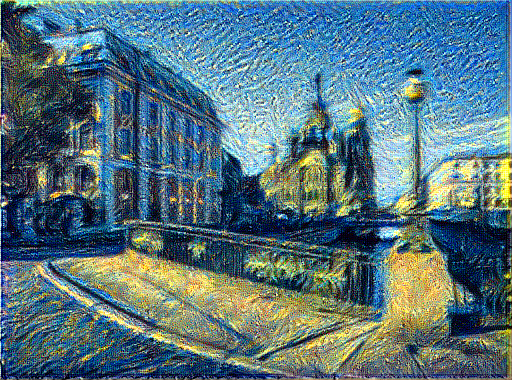

Train step: 1000


In [26]:

# define style and content weight
style_weight =  0.45
content_weight = 1e-32 

# define optimizer. learning rate decreases per epoch.
adam = tf.optimizers.Adam(tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=80.0, decay_steps=100, decay_rate=0.80))

# start the neural style transfer
generated_image, display_images = fit_style_transfer(style_image=style_image, content_image=content_image, 
                                                    style_weight=style_weight, content_weight=content_weight,
                                                    optimizer=adam, epochs=10, steps_per_epoch=100)

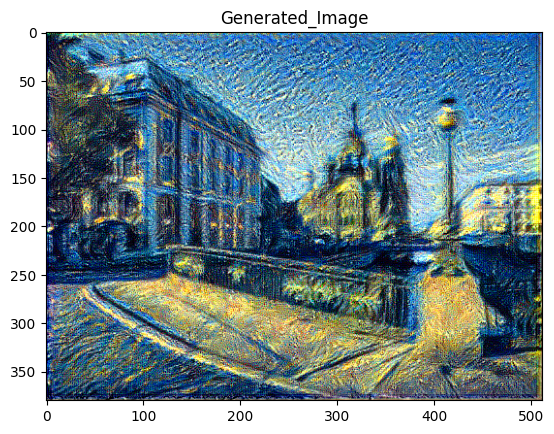

In [27]:
imshow(generated_image, 'Generated_Image')

In [29]:
plt.savefig('generated_image.jpg')

<Figure size 640x480 with 0 Axes>